## Глубокое обучение

#### Инициализация Keras

В качестве бэкенда используется jax

Бэкенд должен указываться до импорта keras

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras

print(keras.__version__)

3.9.2


### Классификация

#### Загрузка набора данных для задачи классификации

База данных MNIST (сокращение от "Modified National Institute of Standards and Technology") — объёмная база данных образцов рукописного написания цифр. База данных является стандартом, предложенным Национальным институтом стандартов и технологий США с целью обучения и сопоставления методов распознавания изображений с помощью машинного обучения в первую очередь на основе нейронных сетей. Данные состоят из заранее подготовленных примеров изображений, на основе которых проводится обучение и тестирование систем.

База данных MNIST содержит 60000 изображений для обучения и 10000 изображений для тестирования.

In [2]:
from keras.api.datasets import mnist

(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

#### Отображение данных

Образцы из набора прошли сглаживание и приведены к серому полутоновому изображению размером 28x28 пикселей.

Под каждым изображением представлено соответствующее ему значение целевого признака (класс).

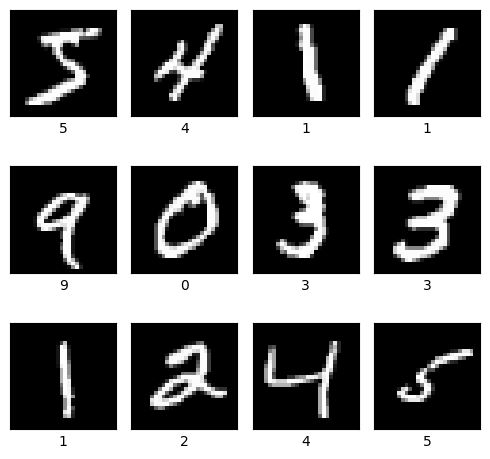

In [3]:
from turtle import width
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(5, 5))
for k in range(12):
    current_axes = axes[k % 3][k % 4]
    current_axes.imshow(X_train[k], cmap='grey')
    current_axes.get_xaxis().set_ticks([])
    current_axes.get_yaxis().set_ticks([])
    current_axes.set_xlabel(y_train[k])
plt.tight_layout()
plt.show()

#### Предобработка данных

Количество классов - 10 (от 0 до 9).

Все изображения из X трансформируются в векторы длиной 784 (28*28) признака и нормализуются.

Для целевых признаков применяется унитарное кодирование в бинарные векторы длиной 10 (нормализация).

In [4]:
n_classes = 10

X_train = X_train.reshape(60000, 784).astype("float32") / 255
X_valid = X_valid.reshape(10000, 784).astype("float32") / 255
y_train = keras.utils.to_categorical(y_train, n_classes)
y_valid = keras.utils.to_categorical(y_valid, n_classes)

display(X_train[0])
display(y_train[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

#### Проектирование архитектуры простой ИНС

Сеть состоит из:
- входного слоя с 784 входами (InputLayer);
- скрытого полносвязного слоя с 64 sigmoid-нейронами (dense_2);
- выходного слоя с 10 softmax-нейронами (многоклассовая классификация) (dense_3).

Количество параметров в слоях:
- dense_2: 784 * 64 + 64 = 50 176 + 64 = 50 240. У каждого из 64 нейронов 784 входа с 784 параметрами (w * x) + 64 смещения (b).
- dense_3: 64 * 10 + 10 = 640 + 10 = 650.

Всего параметров: 50 240 + 650 = 50 890.

Все параметры настраиваются в процессе обучения.

In [5]:
from keras.api.models import Sequential
from keras.api.layers import Dense, InputLayer

simple_model = Sequential()
simple_model.add(InputLayer(shape=(28*28,)))
simple_model.add(Dense(64, activation="sigmoid"))
simple_model.add(Dense(n_classes, activation="softmax"))
simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

#### Обучение простой модели

Функция стоимости: MSE (квадратичная функция)

Оптимизатор: стохастический градиентный спуск (SGD)

Скорость обучения: 0.01

Количество эпох: 200

Размер пакета: 128

Всего пакетов: 60 000 / 128 = 468.75 (468 пакетов по 128 изображений и 1 пакет с 96 изображениями)

Метрика оценки качества: accuracy

Оценка качества и стоимость на обучающей выборке:\
accuracy: 0.4650 - loss: 0.0849

Оценка качества и стоимость на тестовой выборке:\
val_accuracy: 0.4703 - val_loss: 0.0845

In [6]:
from keras.api.optimizers import SGD

simple_model.compile(
    loss="mean_squared_error",
    optimizer=SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

simple_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(X_valid, y_valid),
)

Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1217 - loss: 0.0930 - val_accuracy: 0.1302 - val_loss: 0.0919
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.1303 - loss: 0.0916 - val_accuracy: 0.1377 - val_loss: 0.0909
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.1397 - loss: 0.0906 - val_accuracy: 0.1498 - val_loss: 0.0902
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.1451 - loss: 0.0901 - val_accuracy: 0.1616 - val_loss: 0.0897
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.1590 - loss: 0.0896 - val_accuracy: 0.1792 - val_loss: 0.0892
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.1774 - loss: 0.0891 - val_accuracy: 0.2015 - val_loss: 0.0888
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.2010 - loss: 0.0888 - val_accuracy: 0.2305 - val_loss: 0.0885
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.2317 - loss: 0.0

#### Оценка качества простой модели

Лучшее качество модели: 86.6 %

In [7]:
simple_model.evaluate(X_valid, y_valid)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.8494 - loss: 0.0299


[0.027035443112254143, 0.8661999702453613]

#### Проектирование архитектуры более сложной ИНС

Добавлен дополнительный скрытый полносвязный слой

Все скрытые слои используют ReLU-нейроны

In [8]:
difficult_model = Sequential()
difficult_model.add(InputLayer(shape=(28 * 28,)))
difficult_model.add(Dense(64, activation="relu"))
difficult_model.add(Dense(64, activation="relu"))
difficult_model.add(Dense(10, activation="softmax"))
difficult_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

#### Обучение более сложной модели

Функция стоимости изменена на перекрестную энтропию (лучше подходит для классификации)

Количество эпох уменьшено с 200 до 20

In [9]:
difficult_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(learning_rate=0.1),
    metrics=["accuracy"],
)

difficult_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7680 - loss: 0.8001 - val_accuracy: 0.9225 - val_loss: 0.2617
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.9279 - loss: 0.2443 - val_accuracy: 0.9413 - val_loss: 0.2026
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9458 - loss: 0.1841 - val_accuracy: 0.9488 - val_loss: 0.1680
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.9555 - loss: 0.1511 - val_accuracy: 0.9585 - val_loss: 0.1303
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9614 - loss: 0.1277 - val_accuracy: 0.9583 - val_loss: 0.1377
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.9669 - loss: 0.1110 - val_accuracy: 0.9658 - val_loss: 0.1079
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.9722 - loss: 0.0937 - val_accuracy: 0.9691 - val_loss: 0.0995
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9745 - loss: 0.0850 - val_

#### Оценка качества более сложной модели

Лучшее качество модели: 97.4 %

При этом количество эпох обучения значительно сократилось (с 200 до 20).

In [10]:
difficult_model.evaluate(X_valid, y_valid)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9689 - loss: 0.1073


[0.08943505585193634, 0.9736999869346619]

#### Проектирование архитектуры глубокой ИНС

В ИНС теперь три скрытых полносвязных слоя с ReLU-нейронами

Для выходов каждого скрытого слоя используется пакетная нормализация

Для последнего скрытого слоя применяется прореживание, при котором отключается 20 % случайных нейронов

Keras автоматически корректирует значения (умножает входы на 0.8)

In [11]:
from keras.api.layers import Dropout
from keras.api.layers import BatchNormalization

deep_model = Sequential()
deep_model.add(InputLayer(shape=(28 * 28,)))
deep_model.add(Dense(64, activation="relu"))
deep_model.add(BatchNormalization())
deep_model.add(Dense(64, activation="relu"))
deep_model.add(BatchNormalization())
deep_model.add(Dense(64, activation="relu"))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.2))
deep_model.add(Dense(10, activation="softmax"))
deep_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,978 (234.29 KB)

 Trainable params: 59,594 (232.79 KB)

 Non-trainable params: 384 (1.50 KB)

#### Обучение глубокой модели

Вместо SGD используется оптимизатор Adam

In [12]:
deep_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

deep_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7737 - loss: 0.7278 - val_accuracy: 0.9490 - val_loss: 0.1610
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9508 - loss: 0.1621 - val_accuracy: 0.9622 - val_loss: 0.1260
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9643 - loss: 0.1164 - val_accuracy: 0.9659 - val_loss: 0.1077
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9716 - loss: 0.0913 - val_accuracy: 0.9672 - val_loss: 0.1038
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9770 - loss: 0.0773 - val_accuracy: 0.9717 - val_loss: 0.0893
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9801 - loss: 0.0647 - val_accuracy: 0.9714 - val_loss: 0.0937
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9806 - loss: 0.0597 - val_accuracy: 0.9731 - val_loss: 0.0951
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9836 - loss: 0.0527 - val_accuracy: 0.

#### Оценка качества глубокой модели

Лучшее качество модели: 97.3 %

Качество модели незначительно улучшилось за счет улучшения архитектуры сети и смены оптимизатора

In [13]:
deep_model.evaluate(X_valid, y_valid)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9674 - loss: 0.1266


[0.10574997216463089, 0.9731000065803528]

### Регрессия

#### Загрузка данных для задачи регрессии

Набор данных о жилье в Бостоне собран Службой переписи населения США.

Входные признаки:
- CRIM — уровень преступности на душу населения по районам;
- ZN — доля жилых земель, отведенных под участки площадью более 25 000 кв. футов;
- INDUS — доля неторговых акров в городе;
- CHAS — 1, если участок граничит с рекой; 0 в противном случае;
- NOX — концентрация оксидов азота;
- RM — среднее количество комнат в помещении;
- AGE — доля домов, построенных до 1940 года;
- DIS — взвешенные расстояния до пяти центров занятости Бостона;
- RAD — индекс доступности радиальных автомагистралей;
- TAX — ставка налога на имущество на полную стоимость;
- PTRATIO — соотношение учеников и учителей по районам;
- B — доля чернокожих по районам;
- LSTAT — % населения с более низким статусом.

Целевой признак:
- MEDV — медианная стоимость домов в тысячах долларов США.

Данные уже предобработаны

In [14]:
from keras.api.datasets import boston_housing

(X_train, y_train), (X_valid, y_valid) = boston_housing.load_data()

display(X_train)
display(y_train)

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

#### Проектирование ИНС для задачи регрессии

Для решения задачи регрессии в выходном слое используются нейроны с линейной функцией активации

Создавать более сложную архитектуру не имеет смысла, так как в наборе данных мало признаков

In [15]:
reg_model = Sequential()
reg_model.add(InputLayer(shape=(13,)))
reg_model.add(Dense(32, activation="relu"))
reg_model.add(BatchNormalization())
reg_model.add(Dense(16, activation="relu"))
reg_model.add(BatchNormalization())
reg_model.add(Dropout(0.2))
reg_model.add(Dense(1, activation="linear"))
reg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 96 (384.00 B)

#### Обучение модели для регрессии

Функция стоимости: MSE (лучше подходит для задачи регрессии)

In [16]:
reg_model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

reg_model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=32,
    validation_data=(X_valid, y_valid),
)

Epoch 1/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 601.7983 - val_loss: 533.4313
Epoch 2/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 565.4746 - val_loss: 511.8965
Epoch 3/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 546.8860 - val_loss: 498.2231
Epoch 4/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 508.6799 - val_loss: 477.7539
Epoch 5/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 459.7863 - val_loss: 449.6629
Epoch 6/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 443.5108 - val_loss: 440.0035
Epoch 7/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 411.8610 - val_loss: 433.9403
Epoch 8/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 401.8837 - val_loss: 403.7916
Epoch 9/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 327.4671 - val_loss: 336.9683
Epoch 10/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 294.0855 - val_loss: 307.6475
Epoch 11/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 263.6659 - val_loss: 284.4071
Epoch 12/

#### Оценка качества модели для регрессии

Средняя ошибка на тестовой выборке: 19.1 тысячи долларов

In [17]:
import numpy as np

y_hat = reg_model.predict(np.reshape(X_valid[42], [1, 13]))
display(y_hat[0][0])
display(y_valid[42])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


17.616888

14.1